# Estudio de distribución y unidades de medida de las variables en MIMIC

El objetivo de este notebook es estudiar la distribución de las variables de interés de MIMIC para asegurar las unidades de medida y rango sugeridos.

In [1]:
import psycopg2 as pg
import pandas as pd
import matplotlib.pyplot as plt

# Crear conexión a la base de datos MIMIC
mimic = pg.connect(user='postgres', password='postgres', host='localhost', dbname='mimic')

# Set schema
cursor = mimic.cursor()
cursor.execute('SET search_path TO public,mimiciii')
mimic.commit()
cursor.close()

In [2]:
def plot_results(var, uom, lowerlim, upperlim, includelims, density=False):
    '''Imprime reporte de resultados de la inferencia de unidad de medida y rango.
    
    Parámetros
    ----------
    var : pandas.Series
        Observaciones de la variable a explorar.
    uom : str
        Unidad de medida inferida.
    lowerlim : int
        Límite inferior del rango inferido.
    upperlim : int
        Límite superior del rango inferido.
    includelims : 2-tuple
        Tupla de dos boleanos indicando si los límites inferior y superior deben incluise.
    density : int or False, default False
        Graficar curva de densidad junto al histograma. Si es int, se graficará y se
        utilizará el valor para establecer la sensibilidad de la curva. Se recomienda
        utilizar valores entre 0.1 y 1.
    '''
    # Calcular valores que entrar en los límites inferior (lower) y superior (upper).
    # También elige el caracter adecuado para escribir rango como intervalo (lchar y rchar).
    lower, lchar = (var >= lowerlim, '[') if includelims[0] else (var > lowerlim, ']')
    upper, rchar = (var <= upperlim, ']') if includelims[1] else (var < upperlim, '[')
    selection = var[lower & upper]

    # Graficar distribución global y selección
    fig, axs = plt.subplots(1, 2, figsize=(12, 3))

    quantile = [x / 100 for x in range(0, 100)]
    
    # Distribución global
    axs[0].plot(var.quantile(quantile))
    axs[0].set_title('Distribución de cuantiles del total de datos')
    axs[0].set_xlabel('Cuantil')
    axs[0].set_ylabel('Valor')
    
    # Distribución de la selección
    axs[1].hist(selection, bins=20, density=bool(density), alpha=0.6)
    if density: selection.plot.kde(bw_method=density, ax=axs[1])
    axs[1].set_title('Distribución en rango inferido')
    axs[1].set_xlabel('Valor')
    axs[1].set_ylabel('Densidad / Frecuencia')
    axs[1].set_xlim(lowerlim, upperlim)
    
    plt.tight_layout()
    plt.show()
    plt.close()
    
    # Reporte
    nobs = len(var) # N° de observaciones
    exlower = nobs - len(var[lower]) # N° Obs. excluidas por el límite inferior
    exupper = nobs - len(var[upper]) # N° Obs. excluidas por el límite superior
    include = len(selection) # N° Obs. totales incluidas
    
    pad1 = 19
    col1 = 15
    pad2 = 32
    col2 = max(25, len(uom))
    
    intervalstr = f'{lchar}{lowerlim}, {upperlim}{rchar}'
    includestr = f'{include:>10,} ({(100 * include / nobs):.3f}%)'
    exlowerstr = f'{exlower:>10,} ({(100 * exlower / nobs):.3f}%)'
    exupperstr = f'{exupper:>10,} ({(100 * exupper / nobs):.3f}%)'
    
    head1 = f'Distribución       ' + ' ' * col1
    sepa1 = '-' * (pad1 + col1)
    s_nob = f'N° Observaciones : {nobs:>{col1},}'
    s_min = f'Mínimo           : {var.min():>{col1},.2f}'
    s_max = f'Media            : {var.mean():>{col1},.2f}'
    s_avg = f'Mediana          : {var.quantile(0.50):>{col1},.2f}'
    s_p50 = f'Máximo           : {var.max():>{col1},.2f}'
    s_p01 = f'Percentil 01     : {var.quantile(0.01):>{col1},.2f}'
    s_p05 = f'Percentil 05     : {var.quantile(0.05):>{col1},.2f}'
    s_p95 = f'Percentil 95     : {var.quantile(0.95):>{col1},.2f}'
    s_p99 = f'Percentil 99     : {var.quantile(0.99):>{col1},.2f}'
    
    head2 = f'Inferencia                      ' + ' ' * col2
    sepa2 = '-' * (pad2 + col2)
    s_uom = f'Unidad de medida inferida     : {uom:>{col2}}'
    s_ran = f'Rango                         : {intervalstr:>{col2}}'
    s_inc = f'N° Obs. incluidas             : {includestr:>{col2}}'
    s_exl = f'Excluidos por límite inferior : {exlowerstr:>{col2}}'
    s_exu = f'Excluidos por límite superior : {exupperstr:>{col2}}'

    report = (
        f' {head1} | {head2}\n'
        f' {sepa1}-+-{sepa2}\n'
        f' {s_nob} | {s_uom}\n'
        f' {s_min} | {s_ran}\n'
        f' {s_max} | {s_inc}\n'
        f' {s_avg} | {s_exl}\n'
        f' {s_p50} | {s_exu}\n'
        f' {s_p01} |\n'
        f' {s_p05} |\n'
        f' {s_p95} |\n'
        f' {s_p99} |'
    )

    print(report)

## Heart rate

In [4]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (211, 220045)
        order by var'''
var = pd.read_sql(query, mimic)['var']

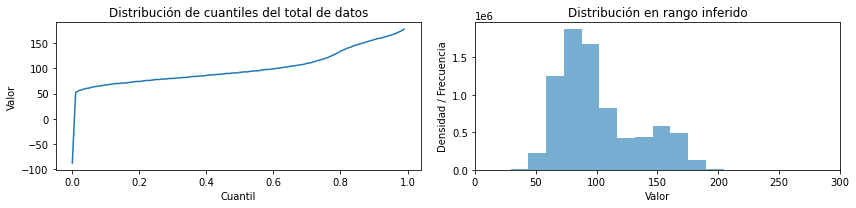

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       7,943,034 | Unidad de medida inferida     :  Latidos por minuto (bpm)
 Mínimo           :          -88.00 | Rango                         :                  ]0, 300[
 Media            :          102.66 | N° Obs. incluidas             :       7,939,068 (99.950%)
 Mediana          :           92.00 | Excluidos por límite inferior :            3,941 (0.050%)
 Máximo           :    9,999,999.00 | Excluidos por límite superior :            1,471 (0.019%)
 Percentil 01     :           52.00 |
 Percentil 05     :           61.00 |
 Percentil 95     :          166.00 |
 Percentil 99     :          178.00 |


In [5]:
plot_results(var, 'Latidos por minuto (bpm)', 0 , 300, (0, 0))

## Respiratory rate

In [6]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (615, 618, 220210, 224690)
        order by var'''
var = pd.read_sql(query, mimic)['var']

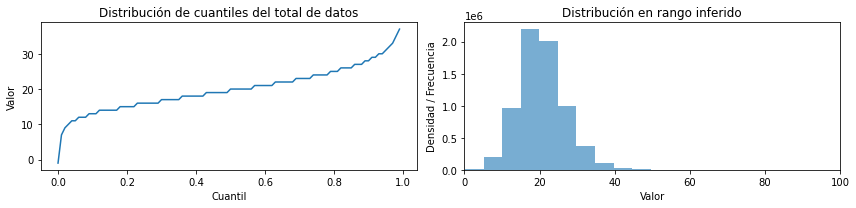

 Distribución                       | Inferencia                                                    
 -----------------------------------+---------------------------------------------------------------
 N° Observaciones :       6,940,625 | Unidad de medida inferida     : Respiraciones por minuto (rpm)
 Mínimo           :           -1.00 | Rango                         :                       ]0, 100[
 Media            :           20.48 | N° Obs. incluidas             :            6,888,715 (99.252%)
 Mediana          :           20.00 | Excluidos por límite inferior :                51,734 (0.745%)
 Máximo           :    2,355,555.00 | Excluidos por límite superior :                 6,334 (0.091%)
 Percentil 01     :            7.00 |
 Percentil 05     :           11.00 |
 Percentil 95     :           31.00 |
 Percentil 99     :           37.00 |


In [7]:
plot_results(var, 'Respiraciones por minuto (rpm)', 0, 100, (0, 0))

## Temperature

In [10]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (223762, 676)
        order by var'''
var = pd.read_sql(query, mimic)['var']

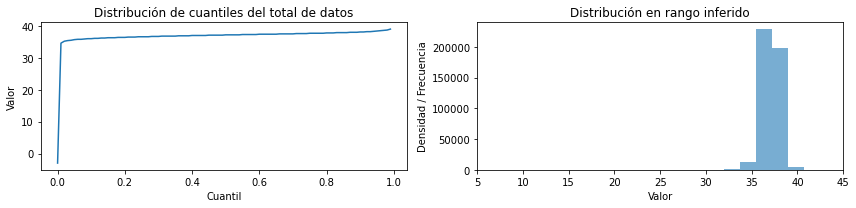

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         452,693 | Unidad de medida inferida     :              Celsius (°C)
 Mínimo           :           -3.00 | Rango                         :                   [5, 45[
 Media            :           37.13 | N° Obs. incluidas             :         445,900 (98.499%)
 Mediana          :           37.20 | Excluidos por límite inferior :            6,285 (1.388%)
 Máximo           :          376.50 | Excluidos por límite superior :            6,365 (1.406%)
 Percentil 01     :           34.60 |
 Percentil 05     :           35.70 |
 Percentil 95     :           38.40 |
 Percentil 99     :           39.00 |


In [11]:
plot_results(var, 'Celsius (°C)', 5, 45, (1, 0))

In [8]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (223761, 678)
        order by var'''
var = pd.read_sql(query, mimic)['var']

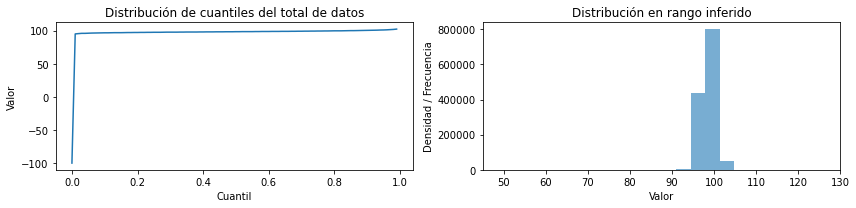

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       1,296,034 | Unidad de medida inferida     :           Fahrenheit (°F)
 Mínimo           :          -99.90 | Rango                         :                 [45, 130[
 Media            :           98.51 | N° Obs. incluidas             :       1,291,918 (99.682%)
 Mediana          :           98.50 | Excluidos por límite inferior :            4,092 (0.316%)
 Máximo           :        9,637.00 | Excluidos por límite superior :            2,971 (0.229%)
 Percentil 01     :           95.10 |
 Percentil 05     :           96.20 |
 Percentil 95     :          101.10 |
 Percentil 99     :          102.40 |


In [9]:
plot_results(var, 'Fahrenheit (°F)', 45, 130, (1, 0))

Items separados por unidad de medida correctamente.

## O2 Saturation

In [12]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (646, 220277)
        order by var'''
var = pd.read_sql(query, mimic)['var']

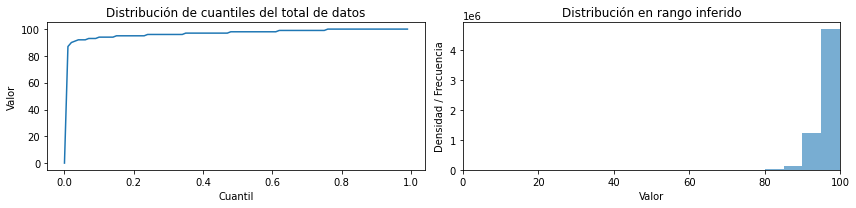

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       6,090,733 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                  ]0, 100]
 Media            :           98.86 | N° Obs. incluidas             :       6,086,440 (99.930%)
 Mediana          :           98.00 | Excluidos por límite inferior :            4,240 (0.070%)
 Máximo           :    6,363,333.00 | Excluidos por límite superior :            3,737 (0.061%)
 Percentil 01     :           87.00 |
 Percentil 05     :           92.00 |
 Percentil 95     :          100.00 |
 Percentil 99     :          100.00 |


In [13]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (0, 1))

## SBP

In [15]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (51, 442, 455, 6701, 220179, 220050)
        order by var'''
var = pd.read_sql(query, mimic)['var']

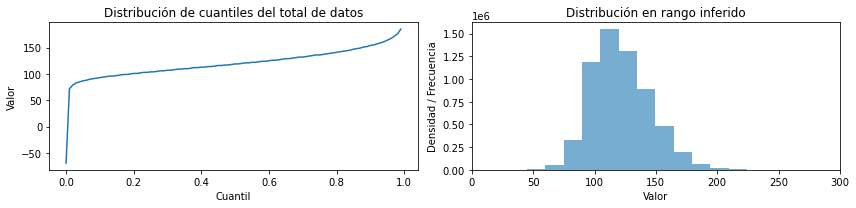

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :       6,138,363 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :          -69.00 | Rango                         :                      ]0, 300[
 Media            :          121.22 | N° Obs. incluidas             :           6,112,350 (99.576%)
 Mediana          :          119.00 | Excluidos por límite inferior :               25,966 (0.423%)
 Máximo           :      141,146.04 | Excluidos por límite superior :               15,215 (0.248%)
 Percentil 01     :           72.00 |
 Percentil 05     :           87.00 |
 Percentil 95     :          164.00 |
 Percentil 99     :          185.00 |


In [16]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

## DBP

In [17]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (8368, 8440, 8441, 8555, 220180, 220051)
        order by var'''
var = pd.read_sql(query, mimic)['var']

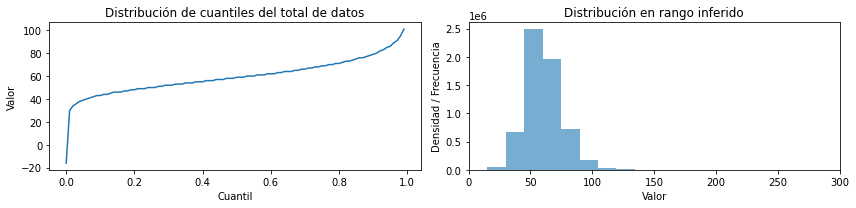

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :       6,119,902 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :          -16.00 | Rango                         :                      ]0, 300[
 Media            :           60.97 | N° Obs. incluidas             :           6,110,062 (99.839%)
 Mediana          :           59.00 | Excluidos por límite inferior :                9,595 (0.157%)
 Máximo           :      114,108.98 | Excluidos por límite superior :                  245 (0.004%)
 Percentil 01     :           30.00 |
 Percentil 05     :           39.00 |
 Percentil 95     :           86.00 |
 Percentil 99     :          101.00 |


In [18]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

## MAP

In [21]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (456, 52, 6702, 443, 220052, 220181, 225312)
        order by var'''
var = pd.read_sql(query, mimic)['var']

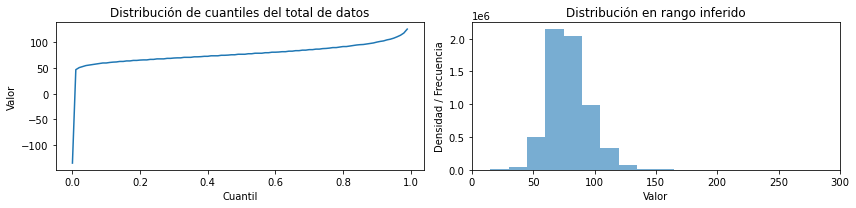

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :       6,183,775 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :         -135.00 | Rango                         :                      ]0, 300[
 Media            :           79.23 | N° Obs. incluidas             :           6,165,291 (99.701%)
 Mediana          :           77.00 | Excluidos por límite inferior :               16,867 (0.273%)
 Máximo           :      120,130.03 | Excluidos por límite superior :               15,049 (0.243%)
 Percentil 01     :           47.00 |
 Percentil 05     :           56.00 |
 Percentil 95     :          108.33 |
 Percentil 99     :          126.00 |


In [22]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

## CVP

In [23]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (113, 220074)
        order by var'''
var = pd.read_sql(query, mimic)['var']

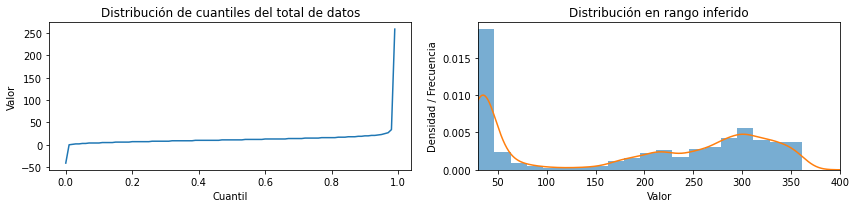

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       1,712,799 | Unidad de medida inferida     :                       N/A
 Mínimo           :          -41.00 | Rango                         :                 [30, 400[
 Media            :           15.58 | N° Obs. incluidas             :           41,693 (2.434%)
 Mediana          :           11.00 | Excluidos por límite inferior :       1,671,099 (97.565%)
 Máximo           :       10,263.00 | Excluidos por límite superior :           16,252 (0.949%)
 Percentil 01     :            0.00 |
 Percentil 05     :            3.00 |
 Percentil 95     :           23.00 |
 Percentil 99     :          259.00 |


In [24]:
plot_results(var, 'N/A', 30, 400, (1, 0), density=0.1)

Mismo problema que en eICU.

## FiO2

In [25]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (190, 3420, 3422, 223835)
        order by var'''
var = pd.read_sql(query, mimic)['var']

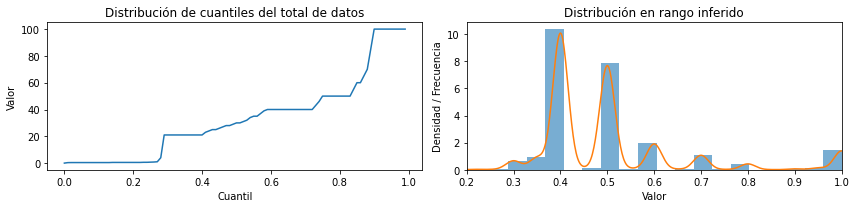

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       2,046,958 | Unidad de medida inferida     :            Fracción (N/A)
 Mínimo           :            0.00 | Rango                         :                  [0.2, 1]
 Media            :           33.63 | N° Obs. incluidas             :         569,169 (27.806%)
 Mediana          :           30.00 | Excluidos por límite inferior :            9,469 (0.463%)
 Máximo           :       10,050.00 | Excluidos por límite superior :       1,477,194 (72.165%)
 Percentil 01     :            0.35 |
 Percentil 05     :            0.40 |
 Percentil 95     :          100.00 |
 Percentil 99     :          100.00 |


In [26]:
plot_results(var, 'Fracción (N/A)', 0.20, 1, (1, 1), density=0.1)

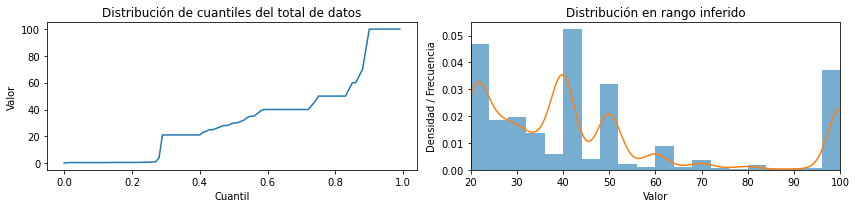

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :       2,046,958 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                 [20, 100]
 Media            :           33.63 | N° Obs. incluidas             :       1,466,818 (71.658%)
 Mediana          :           30.00 | Excluidos por límite inferior :         580,122 (28.341%)
 Máximo           :       10,050.00 | Excluidos por límite superior :            8,892 (0.434%)
 Percentil 01     :            0.35 |
 Percentil 05     :            0.40 |
 Percentil 95     :          100.00 |
 Percentil 99     :          100.00 |


In [27]:
plot_results(var, 'Puntos porcentuales (%)', 20, 100, (1, 1), density=0.1)

En este caso, se presenta una distribución multimodal. Los valores entre 0.20 y 1 se asumen como fracciones, y entre 20 y 100 como porcentajes. Se sugiere descartar valores menores a 0.20 o entre 1 y 20.

## paO2

In [28]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50821
        order by var'''
var = pd.read_sql(query, mimic)['var']

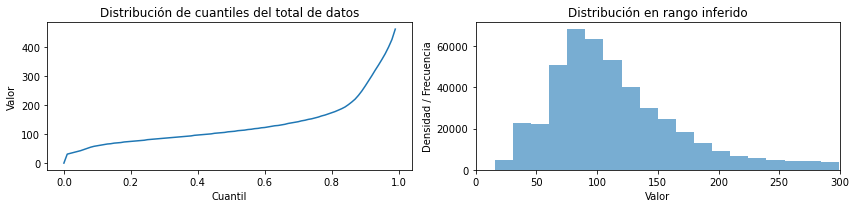

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :         490,628 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :            0.00 | Rango                         :                      ]0, 300[
 Media            :          136.74 | N° Obs. incluidas             :             450,670 (91.856%)
 Mediana          :          109.00 | Excluidos por límite inferior :                  121 (0.025%)
 Máximo           :        1,914.00 | Excluidos por límite superior :               39,943 (8.141%)
 Percentil 01     :           31.00 |
 Percentil 05     :           43.00 |
 Percentil 95     :          358.00 |
 Percentil 99     :          463.00 |


In [29]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 300, (0, 0))

## paCO2

In [30]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50818
        order by var'''
var = pd.read_sql(query, mimic)['var']

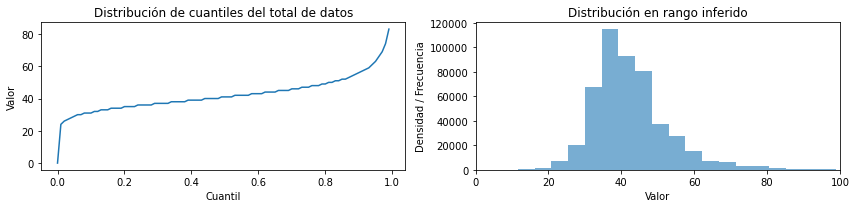

 Distribución                       | Inferencia                                                   
 -----------------------------------+--------------------------------------------------------------
 N° Observaciones :         490,594 | Unidad de medida inferida     : Milímetros de mercurio (mmHg)
 Mínimo           :            0.00 | Rango                         :                      ]0, 100[
 Media            :           42.74 | N° Obs. incluidas             :             488,952 (99.665%)
 Mediana          :           41.00 | Excluidos por límite inferior :                  100 (0.020%)
 Máximo           :          247.00 | Excluidos por límite superior :                1,632 (0.333%)
 Percentil 01     :           24.00 |
 Percentil 05     :           29.00 |
 Percentil 95     :           63.00 |
 Percentil 99     :           83.00 |


In [31]:
plot_results(var, 'Milímetros de mercurio (mmHg)', 0, 100, (0, 0))

## Bilirubin

In [32]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50885
        order by var'''
var = pd.read_sql(query, mimic)['var']

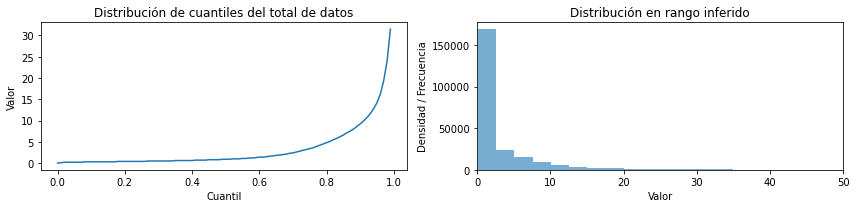

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         238,263 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                          ]0, 50[
 Media            :            3.34 | N° Obs. incluidas             :                237,787 (99.800%)
 Mediana          :            0.90 | Excluidos por límite inferior :                      93 (0.039%)
 Máximo           :           82.80 | Excluidos por límite superior :                     412 (0.173%)
 Percentil 01     :            0.10 |
 Percentil 05     :            0.20 |
 Percentil 95     :           14.20 |
 Percentil 99     :           31.50 |


In [33]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 50, (0, 0))

## Creatinine

In [34]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50912
        order by var'''
var = pd.read_sql(query, mimic)['var']

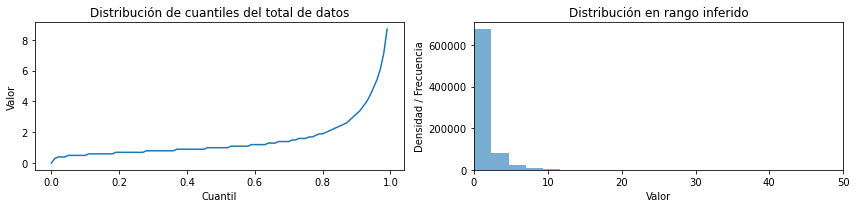

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         797,389 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                          ]0, 50[
 Media            :            1.56 | N° Obs. incluidas             :                797,187 (99.975%)
 Mediana          :            1.00 | Excluidos por límite inferior :                     197 (0.025%)
 Máximo           :          808.00 | Excluidos por límite superior :                     163 (0.020%)
 Percentil 01     :            0.30 |
 Percentil 05     :            0.50 |
 Percentil 95     :            4.90 |
 Percentil 99     :            8.70 |


In [35]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 50, (0, 0))

## BUN

In [36]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51006
        order by var'''
var = pd.read_sql(query, mimic)['var']

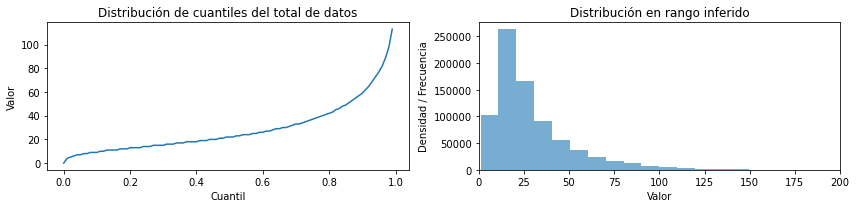

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         791,838 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                         ]0, 200[
 Media            :           29.26 | N° Obs. incluidas             :                791,633 (99.974%)
 Mediana          :           22.00 | Excluidos por límite inferior :                      48 (0.006%)
 Máximo           :          290.00 | Excluidos por límite superior :                     202 (0.026%)
 Percentil 01     :            4.00 |
 Percentil 05     :            7.00 |
 Percentil 95     :           77.00 |
 Percentil 99     :          113.00 |


In [37]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 200, (0, 0))

## Hematocrit

In [38]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51221
        order by var'''
var = pd.read_sql(query, mimic)['var']

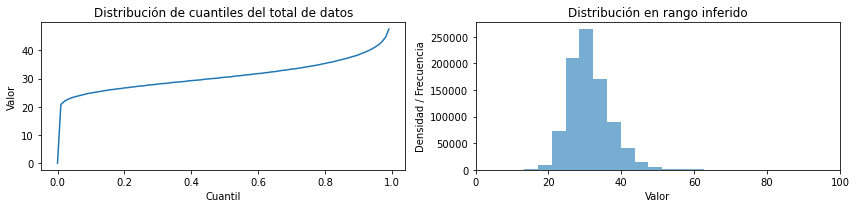

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         881,764 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                  ]0, 100[
 Media            :           31.22 | N° Obs. incluidas             :         881,648 (99.987%)
 Mediana          :           30.50 | Excluidos por límite inferior :              116 (0.013%)
 Máximo           :           77.70 | Excluidos por límite superior :              111 (0.013%)
 Percentil 01     :           20.80 |
 Percentil 05     :           23.50 |
 Percentil 95     :           41.30 |
 Percentil 99     :           47.60 |


In [39]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (0, 0))

## HCO3

In [40]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50882
        order by var'''
var = pd.read_sql(query, mimic)['var']

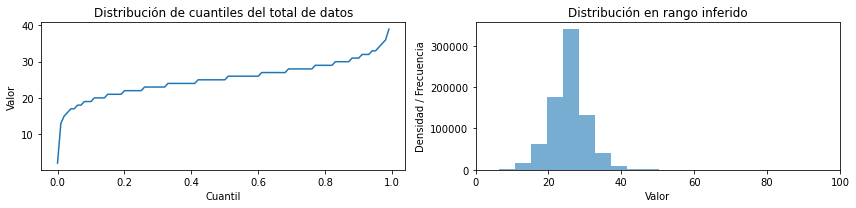

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :         780,648 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            2.00 | Rango                         :                           ]0, 100[
 Media            :           25.41 | N° Obs. incluidas             :                  780,439 (99.973%)
 Mediana          :           25.00 | Excluidos por límite inferior :                       209 (0.027%)
 Máximo           :           90.00 | Excluidos por límite superior :                       209 (0.027%)
 Percentil 01     :           13.00 |
 Percentil 05     :           17.00 |
 Percentil 95     :           33.00 |
 Percentil 99     :           39.00 |


In [41]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 0, 100, (0, 0))

## pH

In [42]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50820
        order by var'''
var = pd.read_sql(query, mimic)['var']

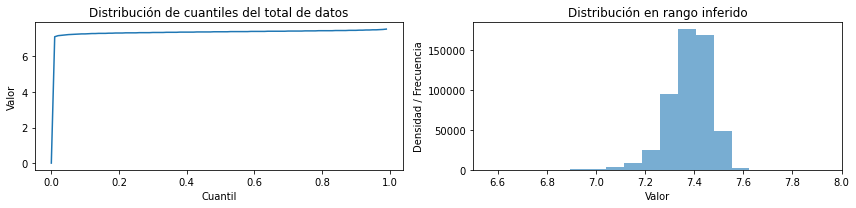

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         530,752 | Unidad de medida inferida     :                       N/A
 Mínimo           :            0.00 | Rango                         :                  ]6.5, 8[
 Media            :            7.38 | N° Obs. incluidas             :         530,641 (99.979%)
 Mediana          :            7.39 | Excluidos por límite inferior :              111 (0.021%)
 Máximo           :            7.99 | Excluidos por límite superior :               95 (0.018%)
 Percentil 01     :            7.11 |
 Percentil 05     :            7.23 |
 Percentil 95     :            7.50 |
 Percentil 99     :            7.54 |


In [43]:
plot_results(var, 'N/A', 6.5, 8, (0, 0))

## Platelets

In [44]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51265
        order by var'''
var = pd.read_sql(query, mimic)['var']

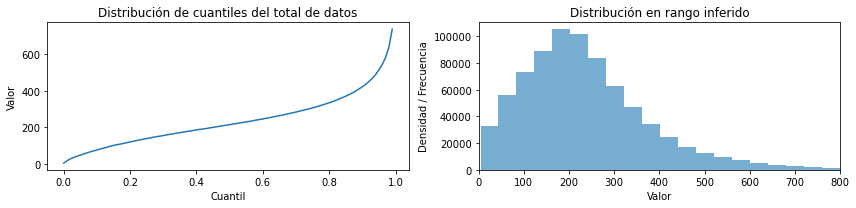

 Distribución                       | Inferencia                                                          
 -----------------------------------+---------------------------------------------------------------------
 N° Observaciones :         778,365 | Unidad de medida inferida     : Miles por milímetro cuadrado (k/mm2)
 Mínimo           :            4.00 | Rango                         :                             ]0, 800[
 Media            :          239.32 | N° Obs. incluidas             :                    772,909 (99.299%)
 Mediana          :          215.00 | Excluidos por límite inferior :                         202 (0.026%)
 Máximo           :        4,504.00 | Excluidos por límite superior :                       5,456 (0.701%)
 Percentil 01     :           17.00 |
 Percentil 05     :           48.00 |
 Percentil 95     :          515.00 |
 Percentil 99     :          739.00 |


In [45]:
plot_results(var, 'Miles por milímetro cuadrado (k/mm2)', 0, 800, (0, 0))

## Potassium

In [46]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50971
        order by var'''
var = pd.read_sql(query, mimic)['var']

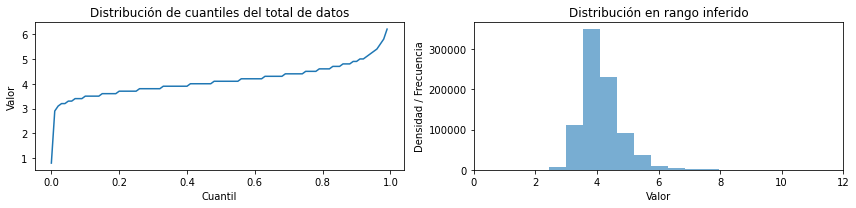

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :         845,737 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            0.80 | Rango                         :                            ]0, 12[
 Media            :            4.15 | N° Obs. incluidas             :                  845,346 (99.954%)
 Mediana          :            4.10 | Excluidos por límite inferior :                       372 (0.044%)
 Máximo           :           27.50 | Excluidos por límite superior :                       391 (0.046%)
 Percentil 01     :            2.90 |
 Percentil 05     :            3.30 |
 Percentil 95     :            5.30 |
 Percentil 99     :            6.20 |


In [47]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 0, 12, (0, 0))

## Sodium

In [48]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50824
        order by var'''
var = pd.read_sql(query, mimic)['var']

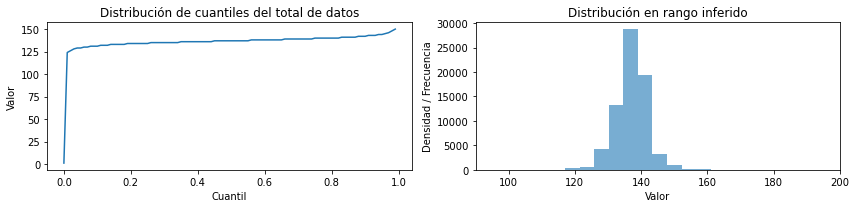

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :          71,504 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            1.07 | Rango                         :                          ]90, 200[
 Media            :          136.98 | N° Obs. incluidas             :                   71,485 (99.973%)
 Mediana          :          137.00 | Excluidos por límite inferior :                        18 (0.025%)
 Máximo           :        1,332.00 | Excluidos por límite superior :                        11 (0.015%)
 Percentil 01     :          124.00 |
 Percentil 05     :          129.00 |
 Percentil 95     :          144.00 |
 Percentil 99     :          150.00 |


In [49]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 90, 200, (0, 0))

## WBC

In [58]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51301 or itemid in (51300, 51301)
        order by var'''
var = pd.read_sql(query, mimic)['var']

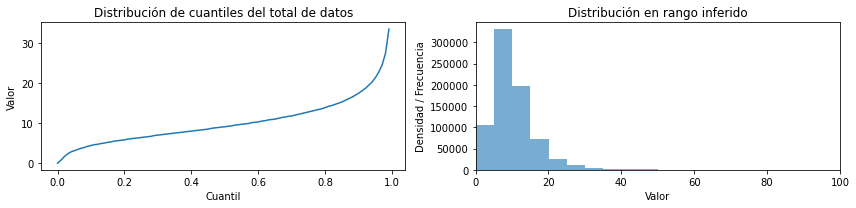

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         755,592 | Unidad de medida inferida     : Miles por microlitros (10^3/mcL)
 Mínimo           :            0.00 | Rango                         :                         ]0, 100[
 Media            :           10.49 | N° Obs. incluidas             :                754,643 (99.874%)
 Mediana          :            9.10 | Excluidos por límite inferior :                     421 (0.056%)
 Máximo           :          846.70 | Excluidos por límite superior :                     936 (0.124%)
 Percentil 01     :            0.70 |
 Percentil 05     :            3.10 |
 Percentil 95     :           21.40 |
 Percentil 99     :           33.50 |


In [59]:
plot_results(var, 'Miles por microlitros (10^3/mcL)', 0, 100, (0, 0))

## Lymphocytes

In [56]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51244
        order by var'''
var = pd.read_sql(query, mimic)['var']

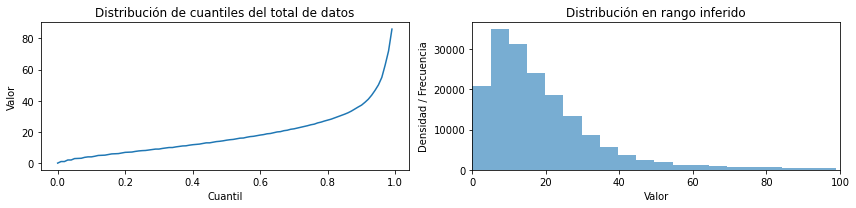

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         172,131 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                  [0, 100[
 Media            :           18.87 | N° Obs. incluidas             :         171,637 (99.713%)
 Mediana          :           14.70 | Excluidos por límite inferior :               31 (0.018%)
 Máximo           :          100.00 | Excluidos por límite superior :              494 (0.287%)
 Percentil 01     :            1.00 |
 Percentil 05     :            2.90 |
 Percentil 95     :           50.20 |
 Percentil 99     :           86.00 |


In [57]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (1, 0))

## Neutrophils

In [60]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51256
        order by var'''
var = pd.read_sql(query, mimic)['var']

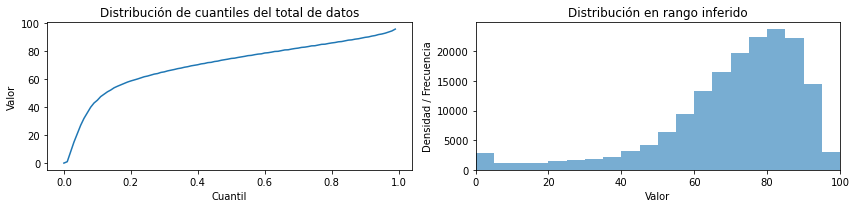

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         172,131 | Unidad de medida inferida     :   Puntos porcentuales (%)
 Mínimo           :            0.00 | Rango                         :                  [0, 100]
 Media            :           70.27 | N° Obs. incluidas             :         172,100 (99.982%)
 Mediana          :           74.90 | Excluidos por límite inferior :               31 (0.018%)
 Máximo           :          100.00 | Excluidos por límite superior :               31 (0.018%)
 Percentil 01     :            1.00 |
 Percentil 05     :           27.00 |
 Percentil 95     :           92.40 |
 Percentil 99     :           95.90 |


In [61]:
plot_results(var, 'Puntos porcentuales (%)', 0, 100, (1, 1))

## AST

In [62]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50878
        order by var'''
var = pd.read_sql(query, mimic)['var']

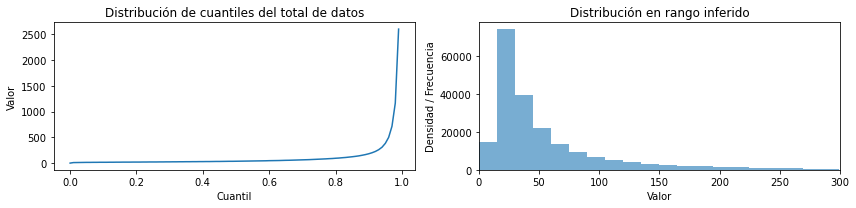

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         219,452 | Unidad de medida inferida     :  Unidades por litro (U/L)
 Mínimo           :            0.00 | Rango                         :                  [0, 300[
 Media            :          151.15 | N° Obs. incluidas             :         205,897 (93.823%)
 Mediana          :           36.00 | Excluidos por límite inferior :               15 (0.007%)
 Máximo           :       36,400.00 | Excluidos por límite superior :           13,555 (6.177%)
 Percentil 01     :           10.00 |
 Percentil 05     :           14.00 |
 Percentil 95     :          383.00 |
 Percentil 99     :        2,598.56 |


In [63]:
plot_results(var, 'Unidades por litro (U/L)', 0, 300, (1, 0))

## ALT

In [73]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50861
        order by var'''
var = pd.read_sql(query, mimic)['var']

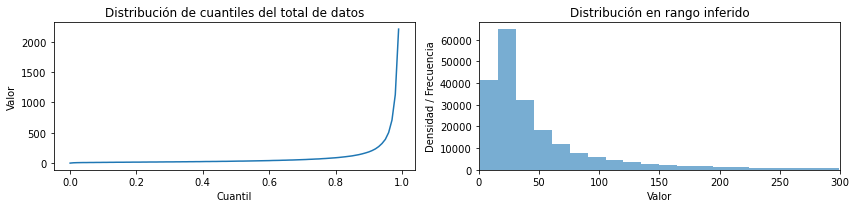

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         219,462 | Unidad de medida inferida     :  Unidades por litro (U/L)
 Mínimo           :            0.00 | Rango                         :                  ]0, 300[
 Media            :          129.97 | N° Obs. incluidas             :         205,290 (93.542%)
 Mediana          :           32.00 | Excluidos por límite inferior :               73 (0.033%)
 Máximo           :       25,460.00 | Excluidos por límite superior :           14,137 (6.442%)
 Percentil 01     :            5.00 |
 Percentil 05     :            9.00 |
 Percentil 95     :          391.00 |
 Percentil 99     :        2,208.00 |


In [74]:
plot_results(var, 'Unidades por litro (U/L)', 0, 300, (0, 0))

## Alkaline Phospatase

In [71]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50863
        order by var'''
var = pd.read_sql(query, mimic)['var']

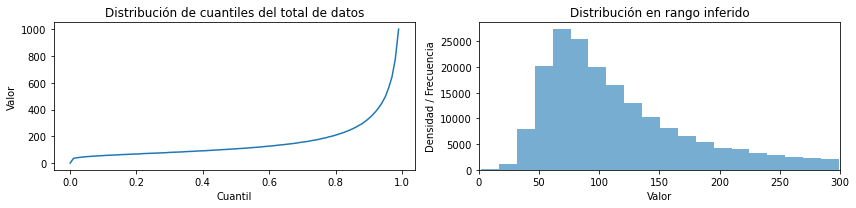

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         207,847 | Unidad de medida inferida     :  Unidades por litro (U/L)
 Mínimo           :            0.00 | Rango                         :                  ]0, 300[
 Media            :          168.29 | N° Obs. incluidas             :         183,428 (88.251%)
 Mediana          :          107.00 | Excluidos por límite inferior :               13 (0.006%)
 Máximo           :        4,695.00 | Excluidos por límite superior :          24,416 (11.747%)
 Percentil 01     :           35.00 |
 Percentil 05     :           48.00 |
 Percentil 95     :          497.00 |
 Percentil 99     :        1,002.00 |


In [72]:
plot_results(var, 'Unidades por litro (U/L)', 0, 300, (0, 0))

## Albumin

In [68]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50862
        order by var'''
var = pd.read_sql(query, mimic)['var']

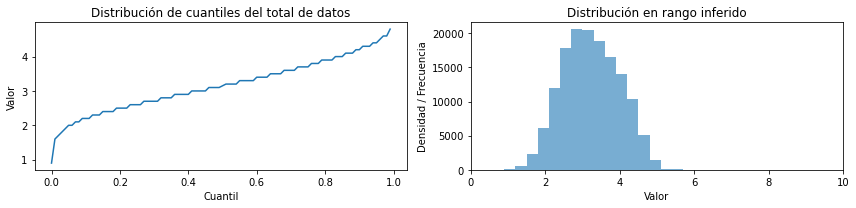

 Distribución                       | Inferencia                                                 
 -----------------------------------+------------------------------------------------------------
 N° Observaciones :         146,694 | Unidad de medida inferida     : Gramos por decilitro (g/dL)
 Mínimo           :            0.90 | Rango                         :                     [0, 10[
 Media            :            3.18 | N° Obs. incluidas             :           146,652 (99.971%)
 Mediana          :            3.15 | Excluidos por límite inferior :                 42 (0.029%)
 Máximo           :            6.90 | Excluidos por límite superior :                 42 (0.029%)
 Percentil 01     :            1.60 |
 Percentil 05     :            2.00 |
 Percentil 95     :            4.40 |
 Percentil 99     :            4.80 |


In [69]:
plot_results(var, 'Gramos por decilitro (g/dL)', 0, 10, (1, 0))

## Glucose

In [64]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50931
        order by var'''
var = pd.read_sql(query, mimic)['var']

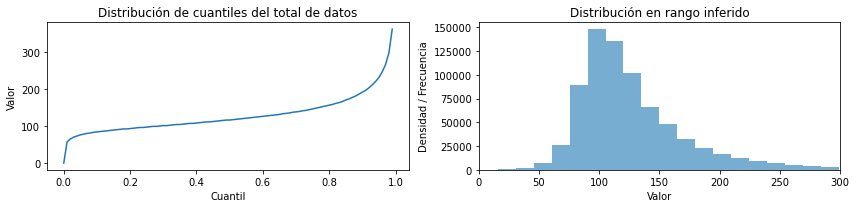

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         748,896 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                         ]0, 300[
 Media            :          131.21 | N° Obs. incluidas             :                734,374 (98.061%)
 Mediana          :          116.00 | Excluidos por límite inferior :                      62 (0.008%)
 Máximo           :        3,565.00 | Excluidos por límite superior :                  14,520 (1.939%)
 Percentil 01     :           57.00 |
 Percentil 05     :           76.00 |
 Percentil 95     :          231.00 |
 Percentil 99     :          361.00 |


In [65]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 300, (0, 0))

## Chloride

In [66]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50902
        order by var'''
var = pd.read_sql(query, mimic)['var']

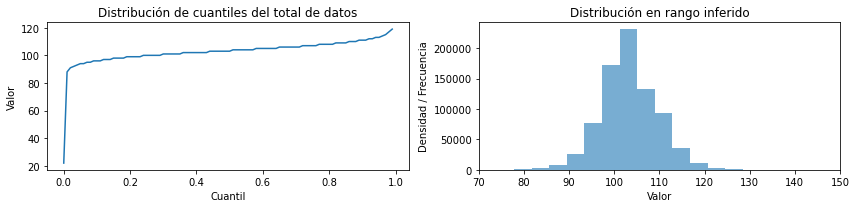

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :         795,480 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :           22.00 | Rango                         :                          [70, 150[
 Media            :          103.48 | N° Obs. incluidas             :                  795,319 (99.980%)
 Mediana          :          103.00 | Excluidos por límite inferior :                       154 (0.019%)
 Máximo           :          155.00 | Excluidos por límite superior :                        75 (0.009%)
 Percentil 01     :           88.00 |
 Percentil 05     :           94.00 |
 Percentil 95     :          113.00 |
 Percentil 99     :          119.00 |


In [67]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 70, 150, (1, 0))

## Base Excess

In [75]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50802
        order by var'''
var = pd.read_sql(query, mimic)['var']

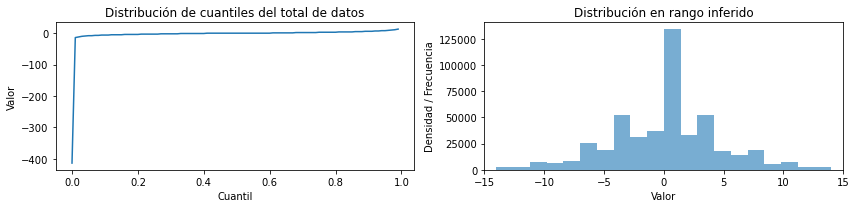

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :         490,651 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :         -414.00 | Rango                         :                          ]-15, 15[
 Media            :           -0.09 | N° Obs. incluidas             :                  481,998 (98.236%)
 Mediana          :            0.00 | Excluidos por límite inferior :                     4,986 (1.016%)
 Máximo           :          162.00 | Excluidos por límite superior :                     3,791 (0.773%)
 Percentil 01     :          -14.00 |
 Percentil 05     :           -8.00 |
 Percentil 95     :            8.00 |
 Percentil 99     :           13.00 |


In [76]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', -15, 15, (0, 0))

## PTT

In [77]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51275
        order by var'''
var = pd.read_sql(query, mimic)['var']

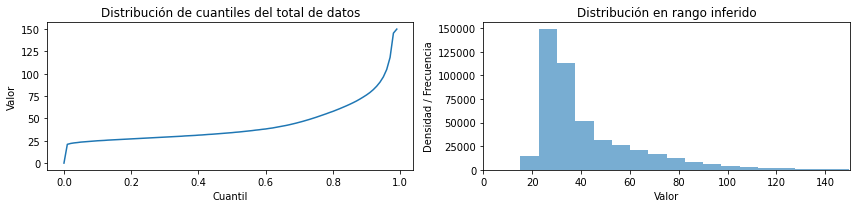

 Distribución                       | Inferencia                                               
 -----------------------------------+----------------------------------------------------------
 N° Observaciones :         474,930 | Unidad de medida inferida     :              Segundos (s)
 Mínimo           :            0.00 | Rango                         :                  ]0, 150[
 Media            :           44.20 | N° Obs. incluidas             :         464,496 (97.803%)
 Mediana          :           34.10 | Excluidos por límite inferior :            1,482 (0.312%)
 Máximo           :          193.30 | Excluidos por límite superior :           10,433 (2.197%)
 Percentil 01     :           21.00 |
 Percentil 05     :           23.50 |
 Percentil 95     :           96.50 |
 Percentil 99     :          150.00 |


In [78]:
plot_results(var, 'Segundos (s)', 0, 150, (0, 0))

## BNP

In [90]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (7294, 227446, 225622)
        order by var'''
var = pd.read_sql(query, mimic)['var']

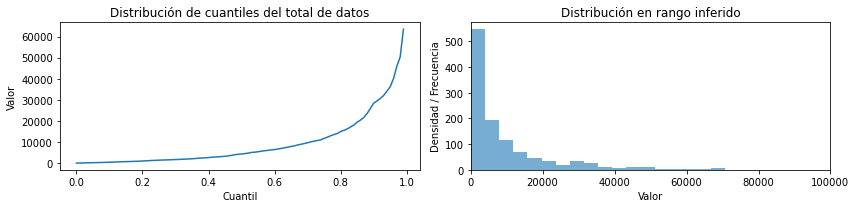

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :           1,143 | Unidad de medida inferida     : Picogramos por mililitro (pg/mL)
 Mínimo           :           10.00 | Rango                         :                      ]0, 100000[
 Media            :        9,471.98 | N° Obs. incluidas             :                 1,143 (100.000%)
 Mediana          :        4,320.00 | Excluidos por límite inferior :                       0 (0.000%)
 Máximo           :       78,684.00 | Excluidos por límite superior :                       0 (0.000%)
 Percentil 01     :           58.26 |
 Percentil 05     :          215.10 |
 Percentil 95     :       36,237.10 |
 Percentil 99     :       63,509.86 |


In [92]:
plot_results(var, 'Picogramos por mililitro (pg/mL)', 0, 100000, (0, 0))

In [93]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50963
        order by var'''
var = pd.read_sql(query, mimic)['var']

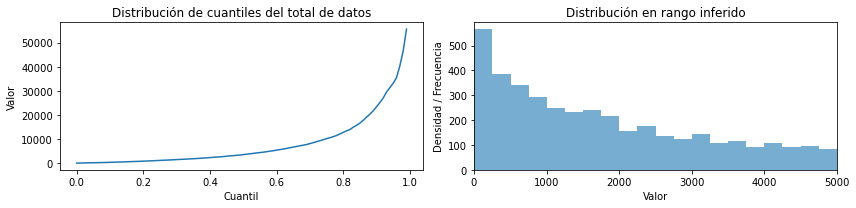

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :           6,943 | Unidad de medida inferida     : Picogramos por mililitro (pg/mL)
 Mínimo           :            6.00 | Rango                         :                        ]0, 5000[
 Media            :        8,223.62 | N° Obs. incluidas             :                  3,954 (56.949%)
 Mediana          :        3,545.00 | Excluidos por límite inferior :                     163 (2.348%)
 Máximo           :      178,367.00 | Excluidos por límite superior :                  2,989 (43.051%)
 Percentil 01     :           41.00 |
 Percentil 05     :          149.00 |
 Percentil 95     :       33,112.10 |
 Percentil 99     :       55,628.26 |


In [94]:
plot_results(var, 'Picogramos por mililitro (pg/mL)', 0, 5000, (0, 0))

Esto hay que revisarlo a detalle. Por ahora utilizar los datos provinientes de `chartevents`. Los de `labevents` corresponden a NTproBNP. https://www.sciencedirect.com/science/article/abs/pii/S016752730800154X

## Fibrinogen

In [95]:
query = f'''select valuenum::numeric as var
        from chartevents
        where itemid in (1528, 227468, 806, 220541)
        order by var'''
var = pd.read_sql(query, mimic)['var']

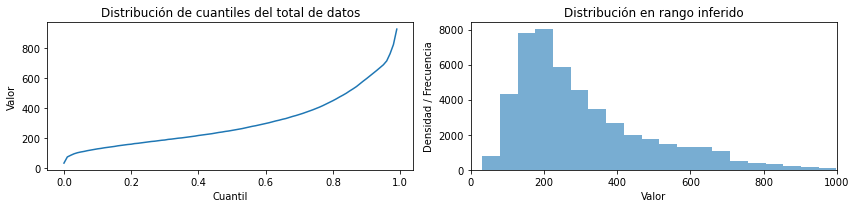

 Distribución                       | Inferencia                                                       
 -----------------------------------+------------------------------------------------------------------
 N° Observaciones :          48,716 | Unidad de medida inferida     : Milígramos por decilitros (mg/dL)
 Mínimo           :           31.00 | Rango                         :                         ]0, 1000[
 Media            :          328.99 | N° Obs. incluidas             :                  48,130 (98.797%)
 Mediana          :          249.00 | Excluidos por límite inferior :                      327 (0.671%)
 Máximo           :      999,999.00 | Excluidos por límite superior :                      586 (1.203%)
 Percentil 01     :           72.00 |
 Percentil 05     :          105.00 |
 Percentil 95     :          686.00 |
 Percentil 99     :          924.00 |


In [96]:
plot_results(var, 'Milígramos por decilitros (mg/dL)', 0, 1000, (0, 0))

In [82]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 51214
        order by var'''
var = pd.read_sql(query, mimic)['var']

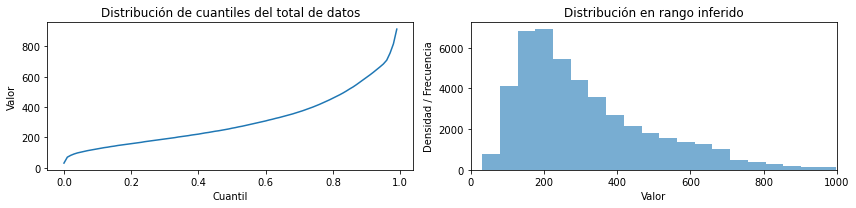

 Distribución                       | Inferencia                                                       
 -----------------------------------+------------------------------------------------------------------
 N° Observaciones :          45,935 | Unidad de medida inferida     : Milígramos por decilitros (mg/dL)
 Mínimo           :           31.00 | Rango                         :                         ]0, 1000[
 Media            :          314.71 | N° Obs. incluidas             :                  45,631 (99.338%)
 Mediana          :          261.00 | Excluidos por límite inferior :                       74 (0.161%)
 Máximo           :        1,773.00 | Excluidos por límite superior :                      304 (0.662%)
 Percentil 01     :           70.00 |
 Percentil 05     :          103.00 |
 Percentil 95     :          684.00 |
 Percentil 99     :          914.00 |


In [83]:
plot_results(var, 'Milígramos por decilitros (mg/dL)', 0, 1000, (0, 0))

Es posble combinar datos de ambas tablas.

## Hemoglobina

In [84]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50811
        order by var'''
var = pd.read_sql(query, mimic)['var']

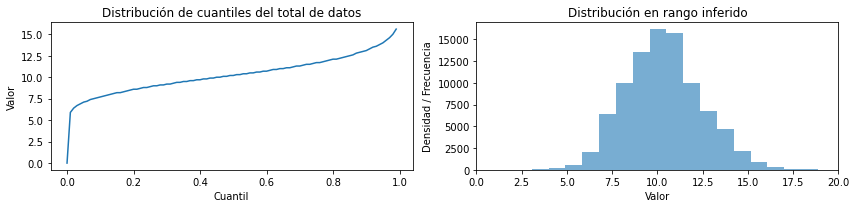

 Distribución                       | Inferencia                                                 
 -----------------------------------+------------------------------------------------------------
 N° Observaciones :          89,712 | Unidad de medida inferida     : Gramos por decilitro (g/dL)
 Mínimo           :            0.00 | Rango                         :                     ]0, 20[
 Media            :           10.35 | N° Obs. incluidas             :            89,670 (99.953%)
 Mediana          :           10.20 | Excluidos por límite inferior :                 24 (0.027%)
 Máximo           :          130.00 | Excluidos por límite superior :                 18 (0.020%)
 Percentil 01     :            5.90 |
 Percentil 05     :            7.10 |
 Percentil 95     :           14.00 |
 Percentil 99     :           15.60 |


In [85]:
plot_results(var, 'Gramos por decilitro (g/dL)', 0, 20, (0, 0))

## Lactate

In [86]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50813
        order by var'''
var = pd.read_sql(query, mimic)['var']

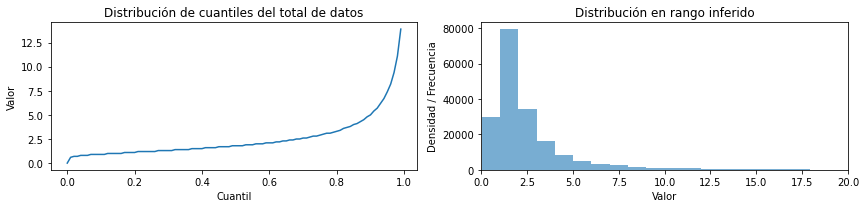

 Distribución                       | Inferencia                                                      
 -----------------------------------+-----------------------------------------------------------------
 N° Observaciones :         187,116 | Unidad de medida inferida     : Milígramos por decilitro (mg/dL)
 Mínimo           :            0.00 | Rango                         :                          ]0, 20[
 Media            :            2.60 | N° Obs. incluidas             :                186,613 (99.731%)
 Mediana          :            1.80 | Excluidos por límite inferior :                      92 (0.049%)
 Máximo           :           36.00 | Excluidos por límite superior :                     502 (0.268%)
 Percentil 01     :            0.60 |
 Percentil 05     :            0.80 |
 Percentil 95     :            7.40 |
 Percentil 99     :           13.90 |


In [87]:
plot_results(var, 'Milígramos por decilitro (mg/dL)', 0, 20, (0, 0))

## Magnesium

In [88]:
query = f'''select valuenum::numeric as var
        from labevents
        where itemid = 50960
        order by var'''
var = pd.read_sql(query, mimic)['var']

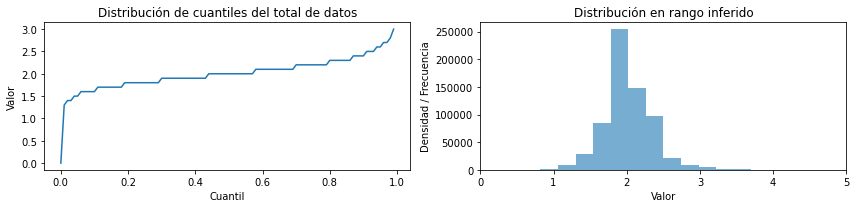

 Distribución                       | Inferencia                                                        
 -----------------------------------+-------------------------------------------------------------------
 N° Observaciones :         664,123 | Unidad de medida inferida     : Miliequivalentes por litro (mEq/L)
 Mínimo           :            0.00 | Rango                         :                             ]0, 5[
 Media            :            2.03 | N° Obs. incluidas             :                  663,796 (99.951%)
 Mediana          :            2.00 | Excluidos por límite inferior :                        47 (0.007%)
 Máximo           :           58.00 | Excluidos por límite superior :                       324 (0.049%)
 Percentil 01     :            1.30 |
 Percentil 05     :            1.50 |
 Percentil 95     :            2.60 |
 Percentil 99     :            3.00 |


In [89]:
plot_results(var, 'Miliequivalentes por litro (mEq/L)', 0, 5, (0, 0))